### Correlation testing and evaluation

0. Get the expression matrices for each window
1. Get two genes (vectors) from expression matrix of branch A
2. Compute correlation between those two vectors $\rightarrow w_1$
3. Get the same genes (vectors) from expression matrix of branch B and compute correlation $\rightarrow w_2$
4. Get the absolut value $|w_1-w_2|$
5. Do it for all windows
6. Determine which correlation method to use
7. Try to evaluate significance of correlation results with permutation test for p-value (not practicable yet)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import glob
import os

/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
PATH_TO_WINDOW_ANNDATA = 'data_files/windows_anndata/'

In [3]:
branchAwindows = []
branchBwindows = []

A_windows_files=(glob.glob(f'{PATH_TO_WINDOW_ANNDATA}*A.h5ad'))
B_windows_files=(glob.glob(f'{PATH_TO_WINDOW_ANNDATA}*B.h5ad'))
A_windows_files = sorted(A_windows_files)
B_windows_files = sorted(B_windows_files)

for i in range(len(A_windows_files)):
    branchAwindows.append(sc.read_h5ad(A_windows_files[i]))
    branchBwindows.append(sc.read_h5ad(B_windows_files[i]))

#### 1. Get two genes (vectors) from expression matrix of branch A

Vector Xa is expression vector for gene X in branch A. <br>
Vector Ya is expression vector for gene Y in branch A. <br>
(Just random vectors for testing)

In [4]:
test = branchAwindows[4].copy()

In [5]:
test.var_names

Index(['0610030E20Rik', '1110004F10Rik', '1700020I14Rik', '1810037I17Rik',
       '1810058I24Rik', '2010111I01Rik', '2210016F16Rik', '2310011J03Rik',
       '2410015M20Rik', '2510002D24Rik',
       ...
       'Zkscan3', 'Zmat2', 'Zmynd11', 'Zmynd8', 'Znrd1', 'Zpr1', 'Zranb2',
       'Zrsr2', 'Zufsp', 'Zwint'],
      dtype='object', name='index', length=2000)

In [6]:
test.obs_vector('Znrd1')

array([-0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
        1.3534448 , -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307, -0.21651307,
       -0.21651307, -0.21651307, -0.21651307, -0.21651307,  5.056215  ,
       -0.21651307,  6.6066732 , -0.21651307, -0.21651307, -0.21

In [7]:
Xa = test.obs_vector('Nrf1')
Ya = test.obs_vector('Psmb1')

#### 2. Compute the correlation <br>
Correlation is computed with numpy.corrcoef(Xa,Ya).

In [8]:
w1 = np.corrcoef(Xa, Ya)[0, 1]
w1

0.20010931316835748

In [9]:
import astropy.stats

In [10]:
w3 = astropy.stats.biweight_midcorrelation(Xa, Ya)
w3

0.2885177550846927

#### 3. Get the same genes (vectors) from expression matrix of branch B and compute correlation

Vector Xb is expression vector for gene X in branch B. <br>
Vector Yb is expression vector for gene Y in branch B.

In [11]:
test = branchBwindows[4].copy()

In [12]:
Xb = test.obs_vector('Nrf1')
Yb = test.obs_vector('Psmb1')

In [13]:
w2 = np.corrcoef(Xb, Yb)[0, 1]
w2

0.13770408886638671

In [14]:
w4 = astropy.stats.biweight_midcorrelation(Xb, Yb)
w4

0.29751276908013824

#### 4. Get the absolute value $|w_1-w_2|$

In [15]:
abs(w1-w2)

0.06240522430197076

In [16]:
abs(w3-w4)

0.008995013995445555

#### Do this for each pair in one window: (no filtering before)

In [17]:
import math

In [18]:
A = branchAwindows[4].copy()
B = branchBwindows[4].copy()

In [19]:
PATH_TO_ABS_MATRICES='data_files/abs_networks/'
dataframe = pd.read_csv(f'{PATH_TO_ABS_MATRICES}win3_abs.csv')
tfs = set(dataframe['TF'])

In [20]:
def filter_df(df, threshold):
    df_new = df[df['abs'] > threshold]
    df_new.reset_index(drop=True, inplace=True)
    return df_new

In [21]:
def get_corr_abs_corrcoef(tfs, A, B):
    correlation_abs = []
    wA=0.
    wB=0.
    for tf in tfs:
        for gene in A.var_names:
            if tf==gene: 
                w=0.
            else:
                wA = np.corrcoef(A.obs_vector(tf), A.obs_vector(gene))[0, 1]
                wB = np.corrcoef(B.obs_vector(tf), B.obs_vector(gene))[0, 1]
                w = abs(wA-wB)
            correlation_abs.append(w)
    return correlation_abs

In [22]:
def get_corr_abs_bicor(tfs, A, B):    
    correlation_abs = []
    wA=0.
    wB=0.
    for tf in tfs:
        for gene in A.var_names:
            if tf==gene: 
                w=0.
            else:
                wA = astropy.stats.biweight_midcorrelation(A.obs_vector(tf), A.obs_vector(gene))
                wB = astropy.stats.biweight_midcorrelation(B.obs_vector(tf), B.obs_vector(gene))
                w = abs(wA-wB)
            correlation_abs.append(w)
    return correlation_abs


In [23]:
def corr_abs_to_df(tfs, A, B):
    rows = []
    for tf in tfs:
        c_tf = tf.split("_")[0]
        for gene in A.var_names:
            if c_tf==gene: 
                w=0.
            else:
                wA = np.corrcoef(A.obs_vector(c_tf), A.obs_vector(gene))[0, 1]
                wB = np.corrcoef(B.obs_vector(c_tf), B.obs_vector(gene))[0, 1]
                w = abs(wA-wB)
            rows.append([tf, gene, w])
    return pd.DataFrame(rows, columns=['TF', 'GENE', 'cc_abs'])

In [24]:
correlation_abs_corrcoef = get_corr_abs_corrcoef(tfs, A, B)
correlation_abs_bicor = get_corr_abs_bicor(tfs, A, B)

/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/astropy/stats/biweight.py:710: RuntimeWarning: invalid value encountered in double_scalars
  return bicorr[0, 1] / (np.sqrt(bicorr[0, 0] * bicorr[1, 1]))


Plot distribution of absolute correlation values:

In [27]:
import matplotlib.pyplot as plt

(array([1.7195e+04, 1.4801e+04, 1.1606e+04, 9.2600e+03, 8.1260e+03,
        7.3530e+03, 6.7920e+03, 6.1720e+03, 5.7690e+03, 5.4280e+03,
        5.0330e+03, 4.5880e+03, 4.3340e+03, 3.9700e+03, 3.6210e+03,
        3.1770e+03, 2.9570e+03, 2.6240e+03, 2.3640e+03, 2.1130e+03,
        1.8810e+03, 1.5840e+03, 1.4760e+03, 1.2080e+03, 1.1200e+03,
        9.7700e+02, 8.5600e+02, 7.3300e+02, 6.3000e+02, 5.6600e+02,
        4.9000e+02, 4.5200e+02, 3.9800e+02, 3.3600e+02, 2.8400e+02,
        2.5900e+02, 1.9800e+02, 1.8600e+02, 2.1700e+02, 1.7300e+02,
        1.6700e+02, 1.6000e+02, 1.3900e+02, 1.0300e+02, 8.9000e+01,
        9.7000e+01, 8.1000e+01, 7.1000e+01, 7.2000e+01, 6.5000e+01,
        6.3000e+01, 4.9000e+01, 4.5000e+01, 4.4000e+01, 2.7000e+01,
        3.5000e+01, 2.3000e+01, 1.7000e+01, 2.0000e+01, 2.1000e+01,
        1.3000e+01, 1.4000e+01, 1.5000e+01, 7.0000e+00, 5.0000e+00,
        1.0000e+01, 6.0000e+00, 8.0000e+00, 6.0000e+00, 6.0000e+00,
        9.0000e+00, 5.0000e+00, 4.0000e+00, 7.00

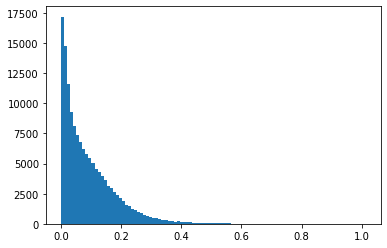

In [28]:
fig, ax = plt.subplots()
ax.hist(correlation_abs_corrcoef, bins=100)

(array([2.0171e+04, 7.9200e+03, 7.6570e+03, 7.2950e+03, 6.9120e+03,
        6.4830e+03, 6.3230e+03, 6.2450e+03, 6.1840e+03, 5.8980e+03,
        5.8340e+03, 5.3010e+03, 5.0810e+03, 4.5730e+03, 4.2530e+03,
        3.8700e+03, 3.4090e+03, 3.2680e+03, 2.8470e+03, 2.6450e+03,
        2.3570e+03, 2.0550e+03, 1.8340e+03, 1.6860e+03, 1.4940e+03,
        1.2710e+03, 1.1340e+03, 1.0300e+03, 8.5000e+02, 7.8600e+02,
        6.9600e+02, 6.2800e+02, 5.0100e+02, 4.8000e+02, 4.7600e+02,
        3.5200e+02, 3.0600e+02, 2.9800e+02, 2.4700e+02, 2.7300e+02,
        2.3000e+02, 1.9400e+02, 1.6100e+02, 1.5000e+02, 1.5200e+02,
        1.2000e+02, 9.7000e+01, 1.3700e+02, 8.2000e+01, 7.4000e+01,
        7.1000e+01, 4.9000e+01, 4.5000e+01, 3.8000e+01, 4.4000e+01,
        3.4000e+01, 4.0000e+01, 2.3000e+01, 1.4000e+01, 1.8000e+01,
        2.1000e+01, 1.6000e+01, 1.2000e+01, 1.2000e+01, 1.3000e+01,
        7.0000e+00, 5.0000e+00, 7.0000e+00, 7.0000e+00, 5.0000e+00,
        6.0000e+00, 2.0000e+00, 3.0000e+00, 0.00

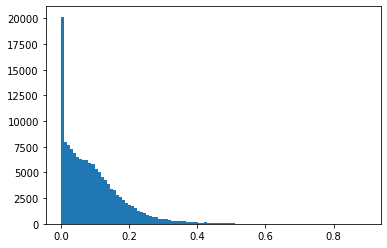

In [29]:
fig, ax = plt.subplots()
ax.hist(correlation_abs_bicor, bins=100)

### 5. Do it for all windows
#### Filtered dataframe before and just compute correlation for remaining tf-gene entries

In [30]:
PATH_TO_ABS_MATRICES = 'data_files/abs_wo0/'

dataframe = pd.read_csv(f'{PATH_TO_ABS_MATRICES}win3_abs.csv')
tfs = set(dataframe['TF'])


In [31]:
dataframe

,TF,GENE,abs
0,Ezh2,4833420G17Rik,4.151750
1,Ezh2,AI467606,0.082890
2,Ezh2,Ablim1,4.325007
3,Ezh2,Acap1,2.208852
4,Ezh2,Acap2,0.129101
...,...,...,...
13852,Rest,Zfp518a,3.991905
13853,Rest,Zfp707,0.763305
13854,Rest,Zfx,1.284463
13855,Rest,Zkscan3,0.432063


In [32]:
w_cc_dataframes = []

for i in range(0, len(branchAwindows)):
    dataframe = pd.read_csv(f'{PATH_TO_ABS_MATRICES}win{i}_abs.csv')
    dataframe = filter_df(dataframe, 0.5) # filter out all values below 0.5
    
    A = branchAwindows[i].copy()
    B = branchBwindows[i].copy() 
    
    rows = []
    
    for index, row in dataframe.iterrows():
        tf = row['TF']
        gene = row['GENE']
        w = row['abs']
        wA = astropy.stats.biweight_midcorrelation(A.obs_vector(tf), A.obs_vector(gene))
        wB = astropy.stats.biweight_midcorrelation(B.obs_vector(tf), B.obs_vector(gene))
        cc_bicor = abs(wA-wB)
        wA = np.corrcoef(A.obs_vector(tf), A.obs_vector(gene))[0, 1]
        wB = np.corrcoef(B.obs_vector(tf), B.obs_vector(gene))[0, 1]
        cc_coef = abs(wA-wB)

        
        rows.append([tf, gene, w, cc_coef, cc_bicor])
    w_cc_dataframes.append(pd.DataFrame(rows, columns=['TF', 'GENE', 'w_abs', 'cc_coef_abs', 'cc_bicor_abs']))    

/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/astropy/stats/biweight.py:710: RuntimeWarning: invalid value encountered in double_scalars
  return bicorr[0, 1] / (np.sqrt(bicorr[0, 0] * bicorr[1, 1]))
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/astropy/stats/biweight.py:710: RuntimeWarning: invalid value encountered in double_scalars
  return bicorr[0, 1] / (np.sqrt(bicorr[0, 0] * bicorr[1, 1]))
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_div

In [33]:
w_cc_dataframes[0]

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs
0,Ezh2,1810037I17Rik,0.759367,0.0,0.0
1,Ezh2,2010111I01Rik,0.643845,0.0,0.0
2,Ezh2,2210016F16Rik,2.120124,0.0,0.0
3,Ezh2,2310011J03Rik,3.651726,0.0,0.0
4,Ezh2,Actr2,3.651726,0.0,0.0
...,...,...,...,...,...
8505,Rest,Zfp326,3.701298,0.0,0.0
8506,Rest,Zfp407,4.984579,0.0,0.0
8507,Rest,Zfp512,0.733906,0.0,0.0
8508,Rest,Zmynd8,1.499678,0.0,0.0


In [34]:
w_cc_dataframes[1]

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs
0,Ezh2,1810037I17Rik,1.800194,0.073319,0.064313
1,Ezh2,2210016F16Rik,3.325726,0.161181,0.164022
2,Ezh2,3830406C13Rik,0.729930,0.029488,0.009544
3,Ezh2,4833420G17Rik,2.802151,0.114864,0.105545
4,Ezh2,4931406P16Rik,0.839976,0.016909,0.009813
...,...,...,...,...,...
11755,Rest,Zc3h7a,2.047629,0.107217,0.114232
11756,Rest,Zcchc6,1.112263,0.075051,0.052891
11757,Rest,Zcchc7,0.947237,0.166832,0.134063
11758,Rest,Zfp110,1.704517,0.180745,0.152108


In [35]:
w_cc_dataframes[2]

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs
0,Ezh2,1810058I24Rik,2.071438,0.410831,0.343949
1,Ezh2,2410015M20Rik,2.838728,0.483066,0.366533
2,Ezh2,3830406C13Rik,2.071438,0.203650,0.208148
3,Ezh2,4833420G17Rik,1.095240,0.192126,0.155420
4,Ezh2,4921524J17Rik,2.865398,0.816723,0.698781
...,...,...,...,...,...
12076,Rest,Zcchc7,0.698076,0.385435,0.245508
12077,Rest,Zfp207,2.790385,0.160590,0.269295
12078,Rest,Zfp407,2.739675,0.478757,0.390642
12079,Rest,Zfp518a,1.521264,NaN,NaN


In [36]:
w_cc_dataframes[3]

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs
0,Ezh2,4833420G17Rik,4.151750,0.169465,0.155415
1,Ezh2,Ablim1,4.325007,0.228184,0.258895
2,Ezh2,Acap1,2.208852,0.176180,0.158432
3,Ezh2,Acot13,1.434090,0.156252,0.076892
4,Ezh2,Adam19,2.973806,0.018931,0.005074
...,...,...,...,...,...
12417,Rest,Zbtb1,7.573699,0.242525,0.198932
12418,Rest,Zfp518a,3.991905,0.172934,0.126091
12419,Rest,Zfp707,0.763305,0.145737,0.107849
12420,Rest,Zfx,1.284463,0.193232,0.075004


In [37]:
w_cc_dataframes[4]

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs
0,Ezh2,0610030E20Rik,3.792624,0.169295,0.142573
1,Ezh2,1810058I24Rik,3.968208,0.195791,0.185573
2,Ezh2,2210016F16Rik,2.470725,0.084101,0.096360
3,Ezh2,2410015M20Rik,3.968208,0.544187,0.297660
4,Ezh2,Abi1,3.908071,0.185623,0.272632
...,...,...,...,...,...
12570,Rest,Zfp518a,2.484976,0.109616,0.142073
12571,Rest,Zfp707,3.353105,0.014814,0.055117
12572,Rest,Zfx,0.528062,0.171519,0.230108
12573,Rest,Zmynd11,1.311668,0.141789,0.153280


Write result dataframes to csv files:

In [38]:
PATH_TO_W_CC_DFS = 'data_files/correlation_abs/'
for i in range(0,len(w_cc_dataframes)):
    df = w_cc_dataframes[i]
    df.to_csv(f'{PATH_TO_W_CC_DFS}w{i}_SCGRN_correlation.csv', index=False)

Plot distribution of Abs[w] and Abs[cc]:

In [39]:
w_vals = []
cc_coef_vals = []
cc_bicor_vals = []

for i in range(len(w_cc_dataframes)):
    w_vals.append([float(x) for x in w_cc_dataframes[i]['w_abs']])
    cc_coef_vals.append( [float(x) for x in w_cc_dataframes[i]['cc_coef_abs']])
    cc_bicor_vals.append( [float(x) for x in w_cc_dataframes[i]['cc_bicor_abs']])
    

In [40]:
def plot(w_vals, cc_coef_vals, cc_bicor_vals, title):
    fig, ax = plt.subplots(3,1, figsize =(10,8), sharey=True )
    ax[0].hist(w_vals, bins=100, label='w_abs')
    ax[0].set_title('Abs[w]')
    ax[1].hist(cc_coef_vals, bins=100, label='cc_coef_abs')
    ax[1].set_title('Abs[cc_coef]')
    ax[2].hist(cc_bicor_vals, bins=100, label='cc_bicor_abs')
    ax[2].set_title('Abs[cc_bicor]')
    fig.suptitle(title, fontsize=16)

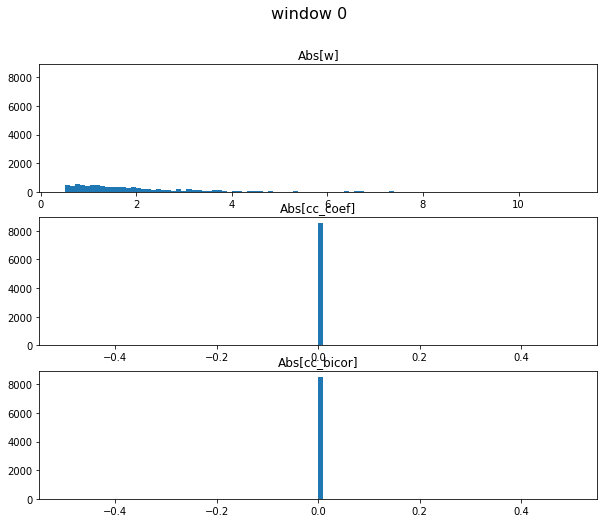

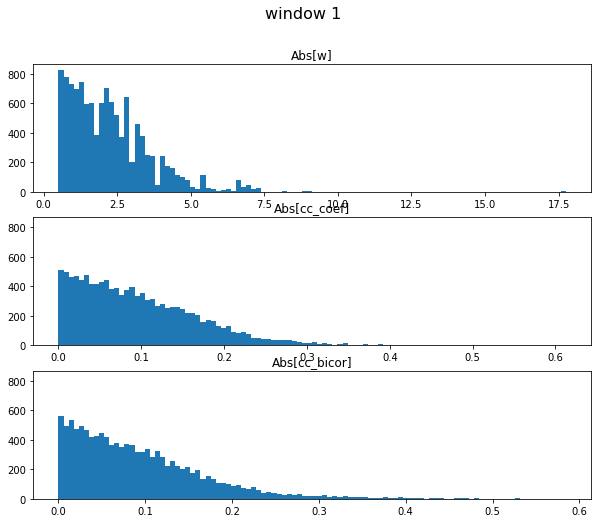

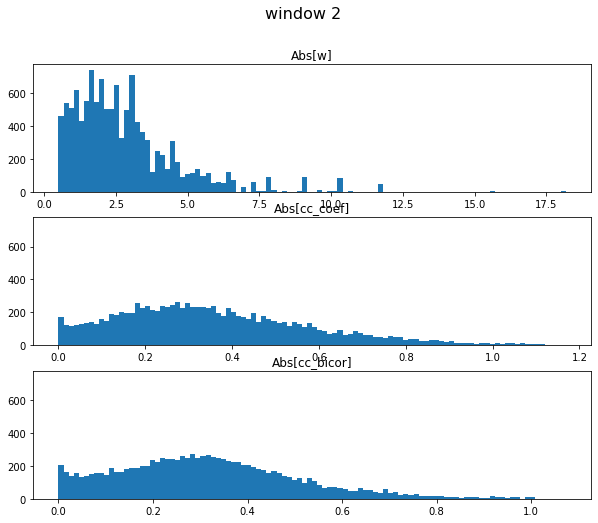

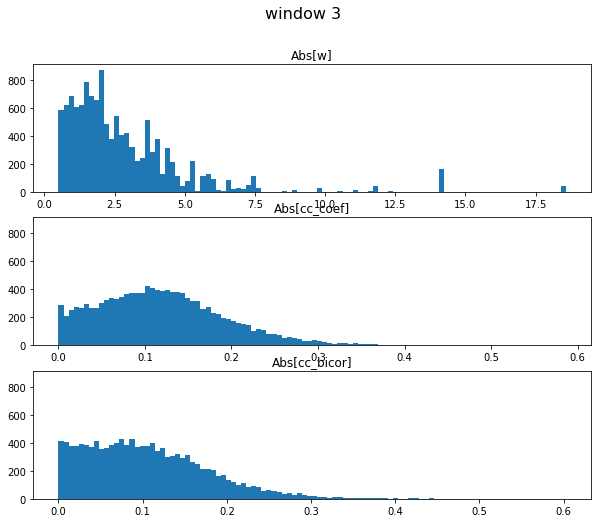

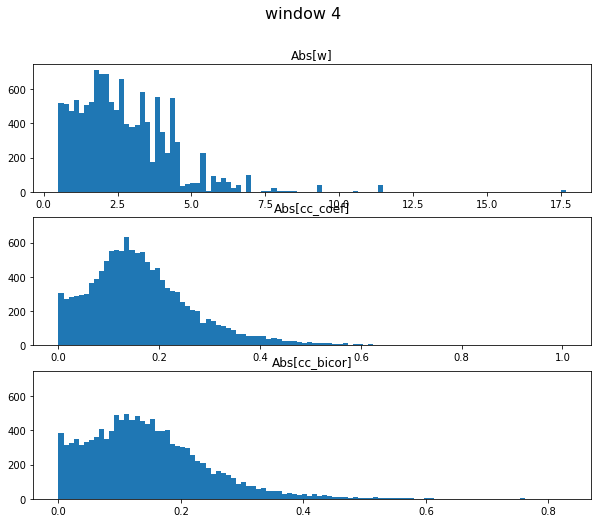

In [41]:
for i in range (0, len(w_vals)):
    plot(w_vals[i], cc_coef_vals[i], cc_bicor_vals[i], f'window {i}')

### 6. Determine which correlation method to use

In [49]:
# method to compare the ranks when sorting by column 1 and by comlumn 2
def compare_ranks(dataframe, column1, column2):
    sums = []
    for tf in set(dataframe['TF']):
        df = dataframe[dataframe['TF']==tf]
        df1 = df.sort_values(column1)
        ranks1 = list(df1.index)
        df2 = df.sort_values(column2)
        ranks2 = list(df2.index)
        
        sum = 0
        for i in range(len(df)):
            sum = sum + abs(ranks1[i]-ranks2[i])
        sum = sum/len(ranks1)
        sums.append(sum)
    
    return sums

In [43]:
df = w_cc_dataframes[4]
sums_coef = compare_ranks(df, 'w_abs', 'cc_coef_abs')
sums_coef

[2.0,
 11.743589743589743,
 9.235294117647058,
 93.05384615384615,
 23.81081081081081,
 3.7333333333333334,
 56.31515151515151,
 52.32258064516129,
 75.93636363636364,
 40.39344262295082,
 2.4285714285714284,
 7.7,
 114.98780487804878,
 4.166666666666667,
 2.6666666666666665,
 20.46875,
 5.818181818181818,
 1.6,
 118.97450424929178,
 15.047619047619047,
 106.06430868167203,
 19.6875,
 158.869918699187,
 5.6923076923076925,
 4.666666666666667,
 2.857142857142857,
 4.142857142857143,
 86.47509578544062,
 6.705882352941177,
 168.98585858585858,
 13.116279069767442,
 3.5,
 26.714285714285715,
 18.166666666666668,
 68.53398058252426,
 13.090909090909092,
 15.5,
 51.77922077922078,
 118.14899713467048,
 211.98742138364778,
 10.64864864864865,
 23.37313432835821,
 184.97826086956522,
 17.818181818181817,
 3.142857142857143,
 124.33333333333333,
 139.3148614609572,
 28.86315789473684,
 115.10843373493977,
 78.81967213114754,
 143.33333333333334,
 161.9205020920502,
 9.8125,
 54.82142857142857,

In [44]:
sums_bicor = compare_ranks(df, 'w_abs', 'cc_bicor_abs')

In [45]:
coef_diff = 0
bicor_diff = 0
for i in range(len(sums_coef)):
    coef_diff += sums_coef[i]
    bicor_diff += sums_bicor[i]
    
coef_diff = coef_diff/len(sums_coef)
bicor_diff = bicor_diff/len(sums_coef)

In [46]:
coef_diff, bicor_diff

(58.660652147613696, 58.69767694738248)

In [47]:
from matplotlib.pyplot import figure

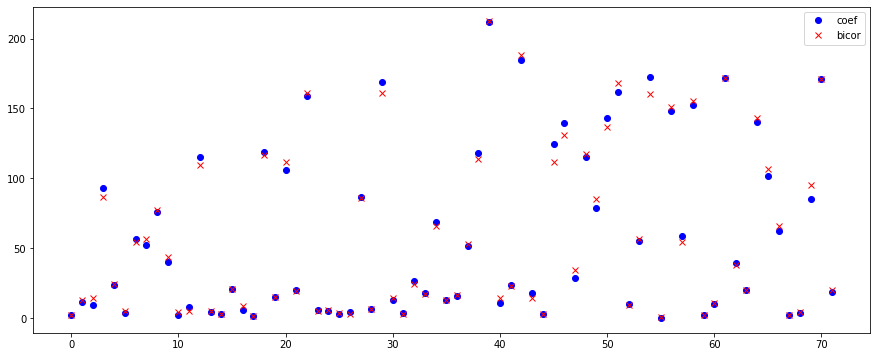

In [48]:
x = [x for x in range(0,72)]

figure(figsize=(15, 6))

plt.plot(x, (sums_coef), 'bo', label='coef')
plt.plot(x, (sums_bicor), 'rx', label='bicor')
plt.legend()


I will use the pearson correlation coefficient but still they don't differ very much.

### 7. Try to evaluate significance of correlation results with permutation test for p-value (not practicable yet)

#### 7.1 Randomize expression matrix

In [50]:
import numpy.random as rd

In [51]:
branchAwindows = []
branchBwindows = []

A_windows_files=(glob.glob(f'{PATH_TO_WINDOW_ANNDATA}*A.h5ad'))
B_windows_files=(glob.glob(f'{PATH_TO_WINDOW_ANNDATA}*B.h5ad'))
A_windows_files = sorted(A_windows_files)
B_windows_files = sorted(B_windows_files)

for i in range(len(A_windows_files)):
    branchAwindows.append(sc.read_h5ad(A_windows_files[i]))
    branchBwindows.append(sc.read_h5ad(B_windows_files[i]))

In [52]:
def shuffle2d(arr2d):
    """Shuffes entries of 2-d array arr2d, preserving shape."""
    list2d = arr2d.tolist()
    reshape = []
    data = []
    iend = 0
    for row in list2d:
        data.extend(row)
        istart, iend = iend, iend+len(row)
        reshape.append((istart, iend))
    rd.shuffle(data)
    return np.array([data[istart:iend] for (istart,iend) in reshape])

Example:

In [53]:
matrix = branchAwindows[3].X
shuffled_matrix = shuffle2d(matrix)

In [54]:
matrix, shuffled_matrix

(array([[-0.29072848, -0.3315403 , -0.47442967, ..., -0.31714624,
         -0.33347058, -0.31607842],
        [-0.29072848, -0.3315403 , -0.47442967, ..., -0.31714624,
         -0.33347058, -0.31607842],
        [-0.29072848,  4.056121  , -0.47442967, ..., -0.31714624,
         -0.33347058, -0.31607842],
        ...,
        [-0.29072848, -0.3315403 , -0.2978558 , ..., -0.31714624,
         -0.33347058,  2.1098306 ],
        [-0.29072848, -0.3315403 , -0.47442967, ..., -0.31714624,
         -0.33347058, -0.31607842],
        [-0.29072848, -0.3315403 , -0.47442967, ..., -0.31714624,
         -0.33347058, -0.31607842]], dtype=float32),
 array([[-0.20748407, -0.2685321 , -0.25669026, ..., -0.21526991,
         -0.40584263, -0.37261307],
        [-0.27228117,  1.15971673, -0.48232967, ..., -0.34254035,
         -0.31028366, -0.45893404],
        [-0.41818815, -0.26284239,  1.2942667 , ..., -0.60374743,
         -0.28113917, -0.17949069],
        ...,
        [-0.45723256,  3.78234363, -0.4

Compute correlation values for 100 randomized matrices and append them to a dataframe with correlation values

In [55]:
# for window 0
matrixA = branchAwindows[0].X
matrixB = branchBwindows[0].X
matA_copy = branchAwindows[0].copy()
matB_copy = branchBwindows[0].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/w0_SCGRN_correlation.csv')
out_dataframe = dataframe

for i in range(100):
    print(f'random matrix {i}')
    shuffled_matA = shuffle2d(matrixA)
    shuffled_matB = shuffle2d(matrixB)
    matA_copy.X = shuffled_matA
    matB_copy.X = shuffled_matB
    corr_col = []
    
    for index, row in dataframe.iterrows():
        tf = row['TF']
        gene = row['GENE']
        wA = np.corrcoef(matA_copy.obs_vector(tf), matA_copy.obs_vector(gene))[0, 1]
        wB = np.corrcoef(matB_copy.obs_vector(tf), matB_copy.obs_vector(gene))[0, 1]
        cc_coef = abs(wA-wB)
        corr_col.append(cc_coef)
    
    out_dataframe[f'random {i}'] = corr_col

random matrix 0
random matrix 1
random matrix 2
random matrix 3
random matrix 4
random matrix 5
random matrix 6
random matrix 7
random matrix 8
random matrix 9
random matrix 10
random matrix 11
random matrix 12
random matrix 13
random matrix 14
random matrix 15
random matrix 16
random matrix 17
random matrix 18
random matrix 19
random matrix 20
random matrix 21
random matrix 22
random matrix 23
random matrix 24
random matrix 25
random matrix 26
random matrix 27
random matrix 28
random matrix 29
random matrix 30
random matrix 31
random matrix 32
random matrix 33
random matrix 34
random matrix 35
random matrix 36
random matrix 37
random matrix 38
random matrix 39
random matrix 40
random matrix 41
random matrix 42
random matrix 43
random matrix 44
random matrix 45
random matrix 46
random matrix 47
random matrix 48
random matrix 49
random matrix 50
random matrix 51
random matrix 52
random matrix 53
random matrix 54
random matrix 55
random matrix 56
random matrix 57
random matrix 58
random 

In [56]:
out_dataframe

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs,random 0,random 1,random 2,random 3,random 4,...,random 90,random 91,random 92,random 93,random 94,random 95,random 96,random 97,random 98,random 99
0,Ezh2,1810037I17Rik,0.759367,0.0,0.0,0.141573,0.187443,0.140750,0.090845,0.170943,...,0.044857,0.050462,0.101005,0.079727,0.104379,0.066838,0.149059,0.108076,0.198730,0.071676
1,Ezh2,2010111I01Rik,0.643845,0.0,0.0,0.247837,0.074895,0.056414,0.086139,0.034460,...,0.031962,0.171828,0.073368,0.135006,0.052079,0.080099,0.190555,0.050349,0.004757,0.016654
2,Ezh2,2210016F16Rik,2.120124,0.0,0.0,0.164798,0.075472,0.116873,0.015009,0.043209,...,0.080394,0.036877,0.014747,0.163786,0.028343,0.116505,0.032195,0.017193,0.042952,0.070206
3,Ezh2,2310011J03Rik,3.651726,0.0,0.0,0.082150,0.082227,0.160136,0.140024,0.037751,...,0.014172,0.014732,0.029537,0.030489,0.064550,0.017432,0.044642,0.217021,0.084769,0.016223
4,Ezh2,Actr2,3.651726,0.0,0.0,0.098336,0.134584,0.040926,0.008271,0.014974,...,0.068731,0.005026,0.080777,0.179003,0.101708,0.011542,0.007658,0.020221,0.053523,0.345400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8505,Rest,Zfp326,3.701298,0.0,0.0,0.065161,0.053761,0.113183,0.037799,0.043411,...,0.159267,0.123309,0.194488,0.112962,0.035218,0.005911,0.022111,0.084952,0.030184,0.007544
8506,Rest,Zfp407,4.984579,0.0,0.0,0.066704,0.118158,0.053080,0.025651,0.096090,...,0.123877,0.135158,0.010307,0.019190,0.034601,0.119896,0.050266,0.078878,0.141204,0.001037
8507,Rest,Zfp512,0.733906,0.0,0.0,0.064585,0.001528,0.042059,0.188767,0.162882,...,0.115525,0.010437,0.072259,0.005476,0.020251,0.095369,0.098025,0.015364,0.150075,0.061293
8508,Rest,Zmynd8,1.499678,0.0,0.0,0.019550,0.035188,0.002834,0.079891,0.129816,...,0.002579,0.115711,0.019467,0.068151,0.022730,0.083652,0.024051,0.018295,0.020815,0.103962


In [57]:
# for window 1
matrixA = branchAwindows[1].X
matrixB = branchBwindows[1].X
matA_copy = branchAwindows[1].copy()
matB_copy = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/w1_SCGRN_correlation.csv')
out_dataframe2 = dataframe

for i in range(100):
    print(f'random matrix {i}')
    shuffled_matA = shuffle2d(matrixA)
    shuffled_matB = shuffle2d(matrixB)
    matA_copy.X = shuffled_matA
    matB_copy.X = shuffled_matB
    corr_col = []
    
    for index, row in dataframe.iterrows():
        tf = row['TF']
        gene = row['GENE']
        wA = np.corrcoef(matA_copy.obs_vector(tf), matA_copy.obs_vector(gene))[0, 1]
        wB = np.corrcoef(matB_copy.obs_vector(tf), matB_copy.obs_vector(gene))[0, 1]
        cc_coef = abs(wA-wB)
        corr_col.append(cc_coef)
    
    out_dataframe2[f'random {i}'] = corr_col

random matrix 0
random matrix 1
random matrix 2
random matrix 3
random matrix 4
random matrix 5
random matrix 6
random matrix 7
random matrix 8
random matrix 9
random matrix 10
random matrix 11
random matrix 12
random matrix 13
random matrix 14
random matrix 15
random matrix 16
random matrix 17
random matrix 18
random matrix 19
random matrix 20
random matrix 21
random matrix 22
random matrix 23
random matrix 24
random matrix 25
random matrix 26
random matrix 27
random matrix 28
random matrix 29
random matrix 30
random matrix 31
random matrix 32
random matrix 33
random matrix 34
random matrix 35
random matrix 36
random matrix 37
random matrix 38
random matrix 39
random matrix 40
random matrix 41
random matrix 42
random matrix 43
random matrix 44
random matrix 45
random matrix 46
random matrix 47
random matrix 48
random matrix 49
random matrix 50
random matrix 51
random matrix 52
random matrix 53
random matrix 54
random matrix 55
random matrix 56
random matrix 57
random matrix 58
random 

In [58]:
out_dataframe2

,TF,GENE,w_abs,cc_coef_abs,cc_bicor_abs,random 0,random 1,random 2,random 3,random 4,...,random 90,random 91,random 92,random 93,random 94,random 95,random 96,random 97,random 98,random 99
0,Ezh2,1810037I17Rik,1.800194,0.073319,0.064313,0.113287,0.063105,0.150345,0.346625,0.059212,...,0.062333,0.148554,0.040941,0.081292,0.238616,0.154349,0.036505,0.072601,0.169645,0.152825
1,Ezh2,2210016F16Rik,3.325726,0.161181,0.164022,0.066083,0.094788,0.294349,0.149165,0.046935,...,0.169953,0.055911,0.100949,0.070887,0.060781,0.037781,0.172746,0.041630,0.112643,0.216104
2,Ezh2,3830406C13Rik,0.729930,0.029488,0.009544,0.074445,0.106442,0.012774,0.096644,0.292691,...,0.054524,0.001573,0.070519,0.136322,0.073395,0.126074,0.010329,0.183610,0.058618,0.021069
3,Ezh2,4833420G17Rik,2.802151,0.114864,0.105545,0.052703,0.358186,0.170185,0.188190,0.083525,...,0.032972,0.055658,0.010152,0.067152,0.017488,0.058235,0.045138,0.159930,0.055771,0.041404
4,Ezh2,4931406P16Rik,0.839976,0.016909,0.009813,0.126701,0.338071,0.012385,0.032387,0.101930,...,0.045997,0.121840,0.157710,0.021286,0.048446,0.115952,0.154234,0.134438,0.039177,0.123738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11755,Rest,Zc3h7a,2.047629,0.107217,0.114232,0.418721,0.129951,0.004503,0.095438,0.011929,...,0.086167,0.063235,0.020508,0.224237,0.067980,0.104951,0.056078,0.123117,0.168167,0.029980
11756,Rest,Zcchc6,1.112263,0.075051,0.052891,0.042276,0.115894,0.076807,0.142061,0.041933,...,0.323494,0.124991,0.190114,0.118167,0.036154,0.056776,0.004326,0.015165,0.031823,0.071005
11757,Rest,Zcchc7,0.947237,0.166832,0.134063,0.050270,0.023260,0.052951,0.422522,0.199744,...,0.088980,0.017932,0.074360,0.245744,0.015430,0.184772,0.031428,0.344297,0.117000,0.127827
11758,Rest,Zfp110,1.704517,0.180745,0.152108,0.165838,0.158022,0.040166,0.035489,0.005364,...,0.029971,0.098692,0.002740,0.093915,0.033433,0.148712,0.169541,0.142538,0.074442,0.056037


In [59]:
# for all windows

out_dfs = []
for j in range(len(branchAwindows)):
    matrixA = branchAwindows[j].X
    matrixB = branchBwindows[j].X
    matA_copy = branchAwindows[j].copy()
    matB_copy = branchBwindows[j].copy()
    dataframe = pd.read_csv(f'data_files/correlation_abs/w{j}_SCGRN_correlation.csv')
    out_dataframe = dataframe

    for i in range(100):
        print(f'random matrix {i}')
        shuffled_matA = shuffle2d(matrixA)
        shuffled_matB = shuffle2d(matrixB)
        matA_copy.X = shuffled_matA
        matB_copy.X = shuffled_matB
        corr_col = []

        for index, row in dataframe.iterrows():
            tf = row['TF']
            gene = row['GENE']
            wA = np.corrcoef(matA_copy.obs_vector(tf), matA_copy.obs_vector(gene))[0, 1]
            wB = np.corrcoef(matB_copy.obs_vector(tf), matB_copy.obs_vector(gene))[0, 1]
            cc_coef = abs(wA-wB)
            corr_col.append(cc_coef)

        out_dataframe[f'random {i}'] = corr_col
    
    out_dfs.append(out_dataframe)
    print(f'window {j} done')

random matrix 0
random matrix 1
random matrix 2
random matrix 3
random matrix 4
random matrix 5
random matrix 6
random matrix 7
random matrix 8
random matrix 9
random matrix 10
random matrix 11
random matrix 12
random matrix 13
random matrix 14
random matrix 15
random matrix 16
random matrix 17
random matrix 18
random matrix 19
random matrix 20
random matrix 21
random matrix 22
random matrix 23
random matrix 24
random matrix 25
random matrix 26
random matrix 27
random matrix 28
random matrix 29
random matrix 30
random matrix 31
random matrix 32
random matrix 33
random matrix 34
random matrix 35
random matrix 36
random matrix 37
random matrix 38
random matrix 39
random matrix 40
random matrix 41
random matrix 42
random matrix 43
random matrix 44
random matrix 45
random matrix 46
random matrix 47
random matrix 48
random matrix 49
random matrix 50
random matrix 51
random matrix 52
random matrix 53
random matrix 54
random matrix 55
random matrix 56
random matrix 57
random matrix 58
random 

random matrix 82
random matrix 83
random matrix 84
random matrix 85
random matrix 86
random matrix 87
random matrix 88
random matrix 89
random matrix 90
random matrix 91
random matrix 92
random matrix 93
random matrix 94
random matrix 95
random matrix 96
random matrix 97
random matrix 98
random matrix 99
window 4 done


In [60]:
out_dfs[0], out_dfs[1]

(        TF           GENE     w_abs  cc_coef_abs  cc_bicor_abs  random 0  \
 0     Ezh2  1810037I17Rik  0.759367          0.0           0.0  0.117190   
 1     Ezh2  2010111I01Rik  0.643845          0.0           0.0  0.040679   
 2     Ezh2  2210016F16Rik  2.120124          0.0           0.0  0.030796   
 3     Ezh2  2310011J03Rik  3.651726          0.0           0.0  0.022006   
 4     Ezh2          Actr2  3.651726          0.0           0.0  0.029727   
 ...    ...            ...       ...          ...           ...       ...   
 8505  Rest         Zfp326  3.701298          0.0           0.0  0.058648   
 8506  Rest         Zfp407  4.984579          0.0           0.0  0.069716   
 8507  Rest         Zfp512  0.733906          0.0           0.0  0.094928   
 8508  Rest         Zmynd8  1.499678          0.0           0.0  0.047972   
 8509  Rest         Zranb2  2.455203          0.0           0.0  0.191484   
 
       random 1  random 2  random 3  random 4  ...  random 90  random 91  

In [61]:
PATH_TO_W_CC_DFS = 'data_files/permutation_correlation/'
for i in range(0,len(out_dfs)):
    df = out_dfs[i]
    df.to_csv(f'{PATH_TO_W_CC_DFS}w{i}_SCGRN_correlation_perm.csv', index=False)

In [ ]:
# for all windows - 10000 permutations

out_dfs_10000 = []
for j in range(len(branchAwindows)):
    matrixA = branchAwindows[j].X
    matrixB = branchBwindows[j].X
    matA_copy = branchAwindows[j].copy()
    matB_copy = branchBwindows[j].copy()
    dataframe = pd.read_csv(f'data_files/correlation_abs/w{j}_SCGRN_correlation.csv')
    out_dataframe = dataframe

    for i in range(10000):
        print(f'random matrix {i}')
        shuffled_matA = shuffle2d(matrixA)
        shuffled_matB = shuffle2d(matrixB)
        matA_copy.X = shuffled_matA
        matB_copy.X = shuffled_matB
        corr_col = []

        for index, row in dataframe.iterrows():
            tf = row['TF']
            gene = row['GENE']
            wA = np.corrcoef(matA_copy.obs_vector(tf), matA_copy.obs_vector(gene))[0, 1]
            wB = np.corrcoef(matB_copy.obs_vector(tf), matB_copy.obs_vector(gene))[0, 1]
            cc_coef = abs(wA-wB)
            corr_col.append(cc_coef)

        out_dataframe[f'random {i}'] = corr_col
    
    out_dfs_10000.append(out_dataframe)
    out_dataframe.to_csv(f'{PATH_TO_W_CC_DFS}w{i}_SCGRN_correlation_perm_10000.csv', index=False)
    print(f'window {j} done')

In [ ]:
matrixA = branchAwindows[0].X
matrixB = branchBwindows[0].X
matA_copy = branchAwindows[0].copy()
matB_copy = branchBwindows[0].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/w0_SCGRN_correlation.csv')
out_dataframe = dataframe

random_dict = {}

for i in range(10000):
    print(f'random matrix {i}')
    shuffled_matA = shuffle2d(matrixA)
    shuffled_matB = shuffle2d(matrixB)
    matA_copy.X = shuffled_matA
    matB_copy.X = shuffled_matB
    corr_col = []

    for index, row in dataframe.iterrows():
        tf = row['TF']
        gene = row['GENE']
        wA = np.corrcoef(matA_copy.obs_vector(tf), matA_copy.obs_vector(gene))[0, 1]
        wB = np.corrcoef(matB_copy.obs_vector(tf), matB_copy.obs_vector(gene))[0, 1]
        cc_coef = abs(wA-wB)
        corr_col.append(cc_coef)

    # out_dataframe[f'random {i}'] = corr_col
    # random_dict[i]=corr_col

# out_dfs_10000.append(out_dataframe)
# out_dataframe.to_csv(f'{PATH_TO_W_CC_DFS}w{0}_SCGRN_correlation_perm_10000.csv', index=False)
# print(f'window {0} done')

In [62]:
def get_p_value(matA, matB, tf, gene, permutations, true_val):
    values = []
    for i in range(permutations):
        shuffled_matA = shuffle2d(matA.X)
        shuffled_matB = shuffle2d(matB.X)
        matA.X = shuffled_matA
        matB.X = shuffled_matB
        wA = np.corrcoef(matA.obs_vector(tf), matA.obs_vector(gene))[0, 1]
        wB = np.corrcoef(matB.obs_vector(tf), matB.obs_vector(gene))[0, 1]
        cc_coef = abs(wA-wB)
        values.append(cc_coef)
    
    counter = 0
    for value in values:
        if value > true_val:
            counter += 1
    p = counter/permutations
    print(p)
    return p

In [64]:
print(f'startet window {3}')
matrixA = branchAwindows[3]
matrixB = branchBwindows[3]

p_vals = []

dataframe = pd.read_csv(f'data_files/correlation_abs/w3_SCGRN_correlation.csv')
out_df = dataframe

for index, row in dataframe.iterrows():
    p = get_p_value(matrixA, matrixB, row['TF'], row['GENE'], 10000, row['cc_coef_abs'])
    p_vals.append(p)

out_df['p-value'] = p_vals
# out_df.to_csv(f'data_files/correlation_abs/w{i}_SCGRN_correlation_perm_10000.csv', index=False)
print(f'finished window {3}')

startet window 3
0.1
0.0
0.04
0.11
0.83
0.79
0.0
0.7
0.3
0.04
0.23
0.47
0.71
0.05
0.18
0.78
0.06
0.27
0.89
0.38
0.08
0.9
0.56
0.07
0.01
0.03
0.06
0.85
0.09
0.02
0.04
0.25
0.26
0.49
0.1
0.17
0.39
0.36
0.03
0.03
0.27
0.07
0.2
0.11
0.74
0.93
0.12
0.49
0.53
0.55
0.13
0.0
0.22
0.35
0.17
0.27
0.74
0.1
0.14
0.22
0.05
0.15
0.4
0.53
0.85
0.0
0.25
0.19
0.63
0.41
0.2
0.38
0.33
0.51
0.18
0.12
0.17
0.88
0.4
0.73
0.81
0.0
0.99
0.5
0.07
0.08
0.18
0.39
0.19
0.09
0.32
0.1
0.67
0.13
0.03
0.16
0.14
0.52
0.29
0.41
0.34
0.0
0.13
0.1
0.27
0.84
0.16
0.83
0.67
0.11
0.45
0.73
0.1
0.11
0.03
0.69
0.54
0.33
0.35
0.0
0.21
0.18
0.49
0.8
0.14
0.51
0.21
0.96
0.89
0.0
0.09
0.07
0.26
0.26
0.18
0.31
0.24
0.13
0.66
0.75
0.04
0.34
0.23
0.06
0.01
0.27
0.16
0.03
0.37
0.05
0.15
0.01
0.03
0.03
0.08
0.43
0.04
0.16
0.18
0.23
0.28
0.79
0.15
0.65
0.37
0.72
0.07
0.98
0.09
0.01
0.04
0.34
0.47
0.5
0.5
0.38
0.05
0.71
0.23
0.04
0.06
0.04
0.12
0.06
0.03
0.19
0.48
0.11
0.33
0.77
0.26
0.26
0.23
0.21
0.53
0.4
0.27
0.38
0.0
0.18
0.11
0.34


KeyboardInterrupt: 

#### 7.2 trying to make the shuffling and correlation computation faster

In [65]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import glob
import os

In [66]:
import multiprocessing
import concurrent.futures
import time
import numpy.random as rd

In [84]:
branchAwindows = []
branchBwindows = []

A_windows_files=(glob.glob(f'data_files/windows_anndata/*A.h5ad'))
B_windows_files=(glob.glob(f'data_files/windows_anndata/*B.h5ad'))
A_windows_files = sorted(A_windows_files)
B_windows_files = sorted(B_windows_files)

for i in range(len(A_windows_files)):
    branchAwindows.append(sc.read_h5ad(A_windows_files[i]))
    branchBwindows.append(sc.read_h5ad(B_windows_files[i]))

In [93]:
def get_shuffled_corrcoef(matA, matB, tf, gene):
    
    # starting time
    start = time.time()
    
    shuffled_matA = shuffle2d_2(matA.X)
    shuffled_matB = shuffle2d_2(matB.X)
    
    # end time
    end = time.time()
    # total time taken
    print(f"Run time for shuffling is {end - start}")
    
    # starting time
    start2 = time.time()
    
    matA.X = shuffled_matA
    matB.X = shuffled_matB
    wA = np.corrcoef(matA.obs_vector(tf), matA.obs_vector(gene))[0, 1]
    wB = np.corrcoef(matB.obs_vector(tf), matB.obs_vector(gene))[0, 1]
    cc_coef = abs(wA-wB)
    
    # end time
    end2 = time.time()
    # total time taken
    print(f"Run time for corrcoef is {end2 - start2}")
    
    return cc_coef

In [94]:
def get_p_value_2(matA, matB, tf, gene, permutations, true_val):
   
    # starting time
    start = time.time()

    values = []
        
    with concurrent.futures.ProcessPoolExecutor() as executor:
        tasks = [executor.submit(get_shuffled_corrcoef, matA, matB, tf, gene) for _ in range(permutations)]
        for task in concurrent.futures.as_completed(tasks):
            values.append(task.result())
    
    counter = 0
    for value in values:
        if value > true_val:
            counter += 1
    p = counter/permutations
    print(p)
    # end time
    end = time.time()
    # total time taken
    print(f"Run time for P-value is {end - start}")

In [95]:
def shuffle2d(arr2d):
    """Shuffes entries of 2-d array arr2d, preserving shape."""
    list2d = arr2d.tolist()
    reshape = []
    data = []
    iend = 0
    for row in list2d:
        data.extend(row)
        istart, iend = iend, iend+len(row)
        reshape.append((istart, iend))
    rd.shuffle(data)
    return np.array([data[istart:iend] for (istart,iend) in reshape])

In [96]:
# def shuffle2d_test(arr2d):
#    shapee = arr2d.shape
#    print(shapee)
#    to1d = shapee[0]*shapee[1]
#    print(to1d)
#    arr2d = arr2d.reshape(to1d,)
#    np.random.shuffle(arr2d)
#    arr2d = arr2d.reshape(shapee)
#    print(arr2d.shape)
#    return 

In [100]:
# method to shuffle gene expression matrix (as 2d array)
def shuffle2d_2(arr2d):
    shapee = arr2d.shape           # save shape of original matrix
    to1d = shapee[0]*shapee[1]     # get size of matrix as 1d array
    arr2d = arr2d.reshape(to1d,)   # reshape matrix into 1d array
    np.random.shuffle(arr2d)       # shuffle array
    arr2d = arr2d.reshape(shapee)  # reshape to original form -> now shuffled
    return arr2d

In [98]:
# shuffle2d_test(matA.X)

In [101]:
#test
matA = branchAwindows[1]
matB = branchBwindows[1]
get_p_value_2(matA, matB, 'Rest', 'Zcchc6', 1, 0.12)

Run time for shuffling is 0.010926008224487305
Run time for corrcoef is 0.002603769302368164
1.0
Run time for P-value is 3.261845827102661


In [102]:
(0.29226231575012207*10000)/60

48.710385958353676

In [103]:
matA = branchAwindows[1]
matB = branchBwindows[1]
get_p_value_2(matA, matB, 'Rest', 'Zcchc6', 10000, 0.12)

Run time for shuffling is 0.011691808700561523


Run time for corrcoef is 0.008134603500366211Run time for shuffling is 0.017081499099731445Run time for corrcoef is 0.003803253173828125
Run time for shuffling is 0.017433643341064453
Run time for corrcoef is 0.003842592239379883
Run time for shuffling is 0.011986255645751953
Run time for corrcoef is 0.0029740333557128906
Run time for shuffling is 0.01213526725769043
Run time for corrcoef is 0.002951383590698242
Run time for shuffling is 0.012038707733154297
Run time for corrcoef is 0.002782106399536133
Run time for shuffling is 0.013411760330200195
Run time for corrcoef is 0.0031762123107910156
Run time for shuffling is 0.0179443359375
Run time for corrcoef is 0.003835439682006836
Run time for shuffling is 0.017591238021850586
Run time for corrcoef is 0.003959178924560547
Run time for shuffling is 0.015452146530151367
Run time for corrcoef is 0.003937244415283203
Run time for shuffling is 0.014491558074951172
Run time for corrcoef is 0.

Run time for corrcoef is 0.002294301986694336
Run time for shuffling is 0.017579078674316406
Run time for corrcoef is 0.0018773078918457031Run time for shuffling is 0.01190495491027832
Run time for corrcoef is 0.001203775405883789
Run time for shuffling is 0.017632484436035156

Run time for shuffling is 0.01183319091796875Run time for corrcoef is 0.0016703605651855469

Run time for corrcoef is 0.0016341209411621094
Run time for shuffling is 0.017911672592163086
Run time for corrcoef is 0.001773834228515625Run time for shuffling is 0.012092351913452148
Run time for corrcoef is 0.001163482666015625Run time for shuffling is 0.018133878707885742Run time for shuffling is 0.012005090713500977



Run time for corrcoef is 0.0018389225006103516Run time for corrcoef is 0.0011782646179199219

Run time for shuffling is 0.017767906188964844
Run time for corrcoef is 0.0017917156219482422
Run time for shuffling is 0.017855167388916016
Run time for shuffling is 0.011635780334472656Run time for corrcoe

Run time for corrcoef is 0.0012614727020263672
Run time for shuffling is 0.017295360565185547
Run time for shuffling is 0.011939048767089844Run time for corrcoef is 0.001947164535522461

Run time for corrcoef is 0.0012357234954833984
Run time for shuffling is 0.01681971549987793
Run time for corrcoef is 0.0021643638610839844Run time for shuffling is 0.011676788330078125

Run time for corrcoef is 0.0018169879913330078Run time for shuffling is 0.011772632598876953

Run time for corrcoef is 0.0012671947479248047
Run time for shuffling is 0.011618375778198242
Run time for corrcoef is 0.0012242794036865234
Run time for shuffling is 0.01697850227355957
Run time for shuffling is 0.011021852493286133
Run time for corrcoef is 0.0018682479858398438
Run time for corrcoef is 0.0011835098266601562
Run time for shuffling is 0.014101028442382812
Run time for corrcoef is 0.0018053054809570312
Run time for shuffling is 0.014087677001953125
Run time for shuffling is 0.01732611656188965
Run time for corr

In [ ]:
%%timeit
get_p_value_2(matA, matB, 'Rest', 'Zcchc6', 1000, 0.12)

In [ ]:
%%timeit
get_p_value_2(matA, matB, 'Rest', 'Zcchc6', 10000, 0.12)

more timing test below (s. TIMING)

In [ ]:
for i in range(2,len(branchAwindows)):
    print(f'startet window {i}')
    matrixA = branchAwindows[i]
    matrixB = branchBwindows[i]

    p_vals = []

    dataframe = pd.read_csv(f'data_files/correlation_abs/w{i}_SCGRN_correlation.csv')
    out_df = dataframe

    processes = []
    # q = Queue()
    for index, row in dataframe.iterrows():
        process = multiprocessing.Process(target=get_p_value_q, args = [matrixA, matrixB, row['TF'], row['GENE'], 5, row['cc_coef_abs']])
        processes.append(process)
        process.start()
        
    for process in processes:
        process.join()
    
    out_df['p-value'] = p_vals
    # out_df.to_csv(f'data_files/correlation_abs/w{i}_SCGRN_correlation_perm_10.csv', index=False)
    print(f'finished window {i}')

#### Using NaNCorrMp.calculate() from https://github.com/bukson/nancorrmp

Testing NaNCorrMp.calculate() first version: dataframe for each tf and regulated genes as input

In [ ]:
def get_dataframes(window_df):
    dataframes = []
    tfs = set(window_df['TF'])
    for tf in tfs:
        df = window_df[window_df['TF'] == tf]
        dataframes.append(df)
    return dataframes

In [ ]:
def get_anndatas(anndata_window, dfs):
    anndatas = {}
    for df in dfs:
        genes = list(df['GENE'])
        tf = list(df['TF'])[0]
        genes.insert(0, tf)
        adata = anndata_window[:,list(genes)]
        anndatas[tf] = adata
    return anndatas

In [ ]:
def get_correlations(anndatasA, anndatasB):
    correlation_abs = {}
    
    tfs = set(anndatasA.keys()).union(set(anndatasB.keys()))
    for tf in tfs:
        # assuming tf appears in both branches
        if tf in anndatasA.keys() and tf in anndatasB.keys():
            start = time.time()
            cA = NaNCorrMp.calculate(anndatasA[tf].to_df(), n_jobs=20)
            cB = NaNCorrMp.calculate(anndatasB[tf].to_df(), n_jobs=20)
            end = time.time()
            # print(f'time for computing correlation for both matrices: {end-start}')
            
            corrA = cA.iloc[0]
            corrB = cB.iloc[0]
            
            genes = set(corrA.index).union(set(corrB.index))
            genes = list(genes)
            
            corrs = []
            for gene in genes:
                if not gene in corrA.index:
                    ccA = 0.0
                    ccB = corrB[gene]
                elif not gene in corrB.index:
                    ccB = 0.0
                    ccA = corrB[gene]
                else:
                    ccA = corrA[gene]
                    ccB = corrB[gene]
                corrs.append(abs(ccA-ccB))     # get the absolute value between branchA and branchB correlation
            
            df = pd.DataFrame([corrs], columns = genes)
            # print(f'genes: {genes}')
            # print(f'dataframe with correlations: {df}')
            correlation_abs[tf]=(df.iloc[0]) # get only first row -> only correlation between tf and gene (not gene-gene)
                
    return correlation_abs

In [ ]:
a1 = branchAwindows[1]
b1 = branchBwindows[1]
df1 = pd.read_csv(f'data_files/correlation_abs/w1_SCGRN_correlation.csv') # test dataframe (window 1)

In [ ]:
dfs = get_dataframes(df1)
dfs

In [ ]:
ada1 = get_anndatas(a1, dfs)
adb1 = get_anndatas(b1, dfs)
ada1

In [ ]:
corr = get_correlations(ada1, adb1)
print(corr)

In [ ]:
print(corr['Trp53'])

timing test for one run:

In [ ]:
df1 = pd.read_csv(f'data_files/correlation_abs/w1_SCGRN_correlation.csv') # test dataframe (window 1)
a1 = branchAwindows[1].copy()
b1 = branchBwindows[1].copy()

dfs = get_dataframes(df1)      # slice original dataframe into dataframes for each tf

start = time.time()

shuffle2d(a1.X)
shuffle2d(b1.X)
print('shuffling done')

ada1 = get_anndatas(a1, dfs)   # get anndata objects with only tf and its genes for each tf
adb1 = get_anndatas(b1, dfs)

print('started computing correlation')
corr = get_correlations(ada1, adb1)   # get list of dfs with absolute correlation values for each tf
print('correlation computed')
end = time.time()

print(f'runtime for one iteration/ permutation: {end-start}')

Testing NaNCorrMp.calculate() second version: whole dataframe as input

In [ ]:
def correlation(inputlist):
    df_a = inputlist[0]
    n_jobs1 = inputlist[1]
    cc = NaNCorrMp.calculate(df_a, n_jobs = n_jobs1)
    return cc

In [ ]:
input_list = [[a1.to_df(), 25],[b1.to_df(), 25]]
res = []

start = time.perf_counter()
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(correlation, input_list)
    for r in results:
        res.append(r)
end = time.perf_counter()
print(f'Finished in {round(end - start, 2)} s')


In [ ]:
df1 = pd.read_csv(f'data_files/correlation_abs/w1_SCGRN_correlation.csv') # test dataframe (window 1)
a1 = branchAwindows[1].copy()
b1 = branchBwindows[1].copy()

counts_larger_than_cc = []
for j in range(len(df1)):            # fill list with 0 for each tf-gene pair
    counts_larger_than_cc.append(0)

# start one permutation
# - shuffle matrices
# - compute correlation in matrix
# - compare true and random values
# start = time.time()

def function1(num):
    # print('start one permutation')
    start1 = time.time()
    for i in range(num):
        start_sh = time.time()
        shuffle2d(a1.X)
        shuffle2d(b1.X)
        end_sh = time.time()
        # print(f'shuffling done in {end_sh - start_sh}')

        start_cc = time.time()


        input_list = [[a1.to_df(), 25],[b1.to_df(), 25]]
        res = []

        start_cc = time.perf_counter()
        with concurrent.futures.ProcessPoolExecutor() as executor:
            results = executor.map(correlation, input_list)
            for r in results:
                res.append(r)
        end_cc = time.perf_counter()
        # print(f'Finished in {round(end_cc - start_cc, 2)} s')

        cA = res[0]
        cB = res[1]

        #cA = NaNCorrMp.calculate(a1.to_df(), n_jobs=30)
        end_cc = time.time()
        #cB = NaNCorrMp.calculate(b1.to_df(), n_jobs=20)
        # end_cc = time.time()
        # print(f'computing correlation done in {end_cc-start_cc}')

        for index, row in df1.iterrows():
            tf = row['TF']
            gene = row['GENE']
            true_cc = row['cc_coef_abs']
            wA = cA.at[tf, gene]
            wB = cB.at[tf, gene]

            if abs(wA-wB) > true_cc:            # compare random correlation to true correlation and count +1 if larger
                counts_larger_than_cc[index] += 1   

        end = time.time()
        # print(f'time for one permutation: {end-start}')

    end1 = time.time()
    print(f'time for {num} permutation: {end1-start1}')
    return counts_larger_than_cc



In [2]:
count_list = function1(5)

NameError: name 'function1' is not defined

In [ ]:
start2 = time.perf_counter()
res_lst = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(function1, [5, 5, 5, 5])    # number of processes !!! (40)
    for r in results:
        res_lst.append(r)
end2 = time.perf_counter()
print(f'Finished in {round(end2 - start2, 2)} s')

In [ ]:
count_list

In [3]:
cA

NameError: name 'cA' is not defined

Better but still too time consuming!

Some more timing tests:


In [ ]:
a1 = branchAwindows[1].copy()
a1

In [ ]:
# test
test = branchBwindows[1].copy()
Xb = test.obs_vector('Nrf1')
Yb = test.obs_vector('Psmb1')
w2 = np.corrcoef(Xb, Yb)[0, 1]
w2


In [ ]:
type(Xb)

In [ ]:
Xb.shape

In [ ]:
random_dataframe = pd.DataFrame(np.random.rand(100, 4))
# corr = NaNCorrMp.calculate(random_dataframe)
random_dataframe

In [ ]:
corr = NaNCorrMp.calculate(random_dataframe)
corr

In [ ]:
w2 = np.corrcoef(random_dataframe[0], random_dataframe[1])
w2

#### TIMING


In [ ]:
window1_A = branchAwindows[1].copy()

start = time.time()
shuffle2d(window1_A.X)
end = time.time()

print(f'runtime for shuffling one matrix: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()

start = time.time()
shuffle2d(window1_A.X)
end = time.time()

print(f'runtime for shuffling one matrix: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test1.csv') # test tf-gene pair (Ezh2 <-> 1810037I17Rik)

start = time.time()
get_counts(dataframe, window1_A, window1_B, 100)
end = time.time()

print(f'runtime for 100 permutation for one tf-gene pair: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test1.csv') # test tf-gene pair (Ezh2 <-> 1810037I17Rik)

start = time.time()
get_counts(dataframe, window1_A, window1_B, 1000)
end = time.time()

print(f'runtime for 1000 permutation for one tf-gene pair: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test1.csv') # test tf-gene pair (Ezh2 <-> 1810037I17Rik)

start = time.time()
get_counts(dataframe, window1_A, window1_B, 10000)
end = time.time()

print(f'runtime for 10000 permutation for one tf-gene pair: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test10.csv') # test for first 10 tf-gene pairs in window 1

start = time.time()
get_counts(dataframe, window1_A, window1_B, 10000)
end = time.time()

print(f'runtime for 10000 permutation for 10 tf-gene pairs: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test100.csv') # test for first 100 tf-gene pairs in window 1

start = time.time()
get_counts(dataframe, window1_A, window1_B, 10000)
end = time.time()

print(f'runtime for 10000 permutation for 100 tf-gene pairs: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/test100.csv') # test for first 100 tf-gene pairs in window 1

start = time.time()
get_counts(dataframe, window1_A, window1_B, 1)
end = time.time()

print(f'runtime one permutation for 100 tf-gene pairs: {end-start} seconds')

In [ ]:
window1_A = branchAwindows[1].copy()
window1_B = branchBwindows[1].copy()
dataframe = pd.read_csv(f'data_files/correlation_abs/w1_SCGRN_correlation.csv') # test with tf-gene pairs from window 1

start = time.time()
get_counts(dataframe, window1_A, window1_B, 1)
end = time.time()

print(f'runtime one permutation for ~11000 tf-gene pairs: {end-start} seconds')

testing on smaller dataframes

In [ ]:
# test 1
dataframe = pd.read_csv(f'data_files/correlation_abs/test100.csv') # test dataframe (first 100 of window 1)
test100_counts = get_counts(dataframe, branchAwindows[1].copy(), branchBwindows[1].copy(), 1000)
print(test100_counts)
p_values = get_p_values(test100_counts, 1000)
print(p_values)

In [ ]:
# test 2
dataframe = pd.read_csv(f'data_files/correlation_abs/test200_300.csv') # test dataframe (entries 200-299 of window 1)
test200_300_counts = get_counts(dataframe, branchAwindows[1].copy(), branchBwindows[1].copy(), 1000)
p_values = get_p_values(test200_300_counts, 1000)
print(p_values)